# 100hz Model evaluation

### Imports

In [1]:
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
import os
import scipy.io as sio
print(tf.config.list_physical_devices()) # Verify you have a GPU available. Not required
print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


### IO data cleaning

**This is a very intricate function and should be used with caution**
* This function goes through each .hea file and deletes the .mat extension that was causing errors in the reading.

In [2]:
folder_path = "../data/WFDB/"
# Loops thorugh the .hea files and re formats them according to WFDB standards. This dataset included a .mat file type at the end and thew an error. 
# This loop modifies the .hea files by only removing the .mat text if its found on the line. 

for filename in os.listdir(folder_path):
    if filename.endswith(".hea"):
        file_path = os.path.join(folder_path, filename)
        
        # Read the contents of the .hea file
        with open(file_path, 'r') as file:
            lines = file.readlines()
        
        # Adjust and format the header lines to remove ".mat" at the end
        adjusted_lines = []
        for line in lines:
            adjusted_line = line.replace(".mat", "")
            adjusted_lines.append(adjusted_line)
        
        # Write the adjusted lines back to the .hea file
        with open(file_path, 'w') as file:
            file.writelines(adjusted_lines)

### Data Loading
* Mat loader: Loads the .mat files independently. Only keeps ecgs with shape (12, 5000) to prevent data mismatch.
* Header Loader: Loads .hea files independently. Uses the wfdb rdheader function to produce a dictionary. 
* Joint function: Loads both the .mat and corresponding header file given that the mat file is of shape (12, 5000)

In [3]:
import os
import numpy as np
import wfdb
import tensorflow as tf
import traceback

folder_path = "../data/WFDB/"

def wfdb_mat_load(path):
    data = []
    for filename in os.listdir(path):
        if filename.endswith(".mat"):
            record_data = sio.loadmat(os.path.join(path, filename))
            if(record_data['val'].shape == (12,5000)):
                data.append(np.array(record_data['val']))
    return data


def wfdb_hea_load(path):
    hea_files = []
    for filename in os.listdir(path):
        if filename.endswith(".hea"):
            base_name, file_type = os.path.splitext(filename)
            file_path = os.path.join(path, base_name)
            header = wfdb.rdheader(path+base_name)
            hea_files.append(header)
    return hea_files

# Incorporates both loading functions so that any data excluded from X is removed from the corresponding Y.
def wfdb_loader(path):
    data = []    
    hea_files = []
    for filename in os.listdir(path):
        if filename.endswith(".mat"):
            record_data = sio.loadmat(os.path.join(path, filename)) # First handles the .mat file
            if record_data['val'].shape == (12, 5000):
                data.append(np.array(record_data['val']))
                header = wfdb.rdheader(path + filename.split(".")[0]) # Switches to .hea file
                hea_files.append(header)
    
    return (tf.cast(tf.transpose(np.array(data), perm=[0, 2, 1])
, dtype=tf.float64)/500), hea_files


sampling_rate = 100

# Load raw signal data
with tf.device('/CPU:0'):
    X_nan, Y_raw = wfdb_loader(folder_path)


#### Raw outputs
* Packaged in Record data types
    * Requires further parsing

In [4]:
Y_raw[0:5], Y_raw[0].comments

([<wfdb.io.record.Record at 0x2492e991280>,
 ['Age: NaN',
  'Sex: Female',
  'Dx: 426783006',
  'Rx: Unknown',
  'Hx: Unknown',
  'Sx: Unknown'])

### Further Data Processing

Converts the raw header data into a Pandas Dataframe. Becomes usable in the form of columns.

In [5]:
Y_nan = []
for hea in Y_raw:
    metadata = {}
    for line in hea.comments[0:]:
        key, value = line.strip("#").split(":")
        metadata[key.strip()] = value.strip()
    Y_nan.append(metadata)

Y_nan = pd.DataFrame(Y_nan)
Y_nan

,Age,Sex,Dx,Rx,Hx,Sx
0,NaN,Female,426783006,Unknown,Unknown,Unknown
1,NaN,Female,426783006,Unknown,Unknown,Unknown
2,NaN,Male,426783006,Unknown,Unknown,Unknown
3,75,Male,"426177001,425623009,164934002,164873001",Unknown,Unknown,Unknown
4,83,Male,"59118001,164889003",Unknown,Unknown,Unknown
...,...,...,...,...,...,...
10287,51,Male,426177001,Unknown,Unknown,Unknown
10288,67,Male,"428417006,426177001",Unknown,Unknown,Unknown
10289,74,Male,"426177001,427393009",Unknown,Unknown,Unknown
10290,48,Female,"445118002,426177001,164934002,164873001",Unknown,Unknown,Unknown


#### Filtering
* Excludes NaN values in the age columns.
* Only keeps ecgs under age 89

In [6]:
with tf.device("/CPU:0"):
    Y_temp = (Y_nan[Y_nan.Age.values != 'NaN'])
    valid_inds = Y_temp.Age.values.astype(int) < 89
    Y = Y_temp[valid_inds]
    X = (X_nan[Y_nan.Age.values != 'NaN'])[valid_inds]

Y.shape, X.shape

((10101, 6), TensorShape([10101, 5000, 12]))

### Downsampling
* The raw ecg data is sampled at 500hz.
* There is a way to preserve curcial information from the ecg while reducing the samplig rate. 
* Scipy signal resampling function

In [7]:
from scipy import signal
with tf.device('/CPU:0'):
    resamp_ratio = 100/500
    X_downsampled = signal.resample(X, 1000, axis=1)

X_downsampled.shape

(10101, 1000, 12)

### Data Augmentation
* We must apply the same transformations as we did on the original dataset

In [8]:
import numpy as np
from scipy import signal

def normalize(X, shape = False):
    # Compute mean and standard deviation along axis 1 and 2
    X_mean = np.mean(X)
    X_std = np.std(X)

    if(shape):
        print(X.shape)
    # Normalize data by subtracting mean and dividing by standard deviation
    return ((X - X_mean) / X_std)

#____________________________________________________________________________________#

bld = 0.5
def baseline_drift(X, baseline, range = 0):
    bld_range = (baseline-range, baseline+range)
    random_shifts = np.random.uniform(bld_range[0], bld_range[1], size = X.shape)
    return X + random_shifts

#____________________________________________________________________________________#

# Define the filter parameters
fs = 100  # Sampling frequency (Hz)
lowcut = 0.5  # Lower cutoff frequency (Hz)
highcut = 40.0  # Higher cutoff frequency (Hz)
filter_order = 4  # Filter order

def bandpass(X, fs, lowcut, highcut, filter_order):
    # Apply bandpass filter to each channel
    filtered_data = np.zeros_like(X)
    for i in range(X.shape[2]):
        for j in range(X.shape[0]):
            b, a = signal.butter(filter_order, [lowcut, highcut], fs=fs, btype='band', output='ba')
            filtered_data[j, :, i] = signal.filtfilt(b, a, X[j, :, i])

    # Print the shape of the filtered data
    return filtered_data

#____________________________________________________________________________________#

def da_apply(X, functions, shape = False):
    X_final = X.copy()

    # Applys DA Augments in specified order
    for func_dict in functions:
        func = func_dict['func']
        if(func_dict['params'] == None):
            X_final = func(X_final)     
        else:
            params = func_dict['params']
            X_final = func(X_final, *params)  

    if(shape == True):
        print(X_final.shape)

    return X_final

#func_dict = [{'func': normalize, 'params': [None]}]

#func_dict = [{'func': baseline_drift, 'params': [0,0.05]}]

# func_dict =[{'func': normalize, 'params': [None]},
#             {'func': bandpass, 'params': [100, 0.5, 10, 3]}, # 100, 0.5, 10, 3
#             {'func': baseline_drift, 'params': [0,0.075]}]

In [9]:
with tf.device('/CPU:0'):
    func_dict =[{'func': normalize, 'params': [None]},  # Normalizing across the entire data set instead of by lead
                {'func': baseline_drift, 'params': [0,0.075]}]  # I found that simulating a 0.075 drift works best

    X_final = da_apply(X_downsampled, func_dict) # If you want to experiment with data shape more, use a smaller data size. Subset X

#### DA visualization

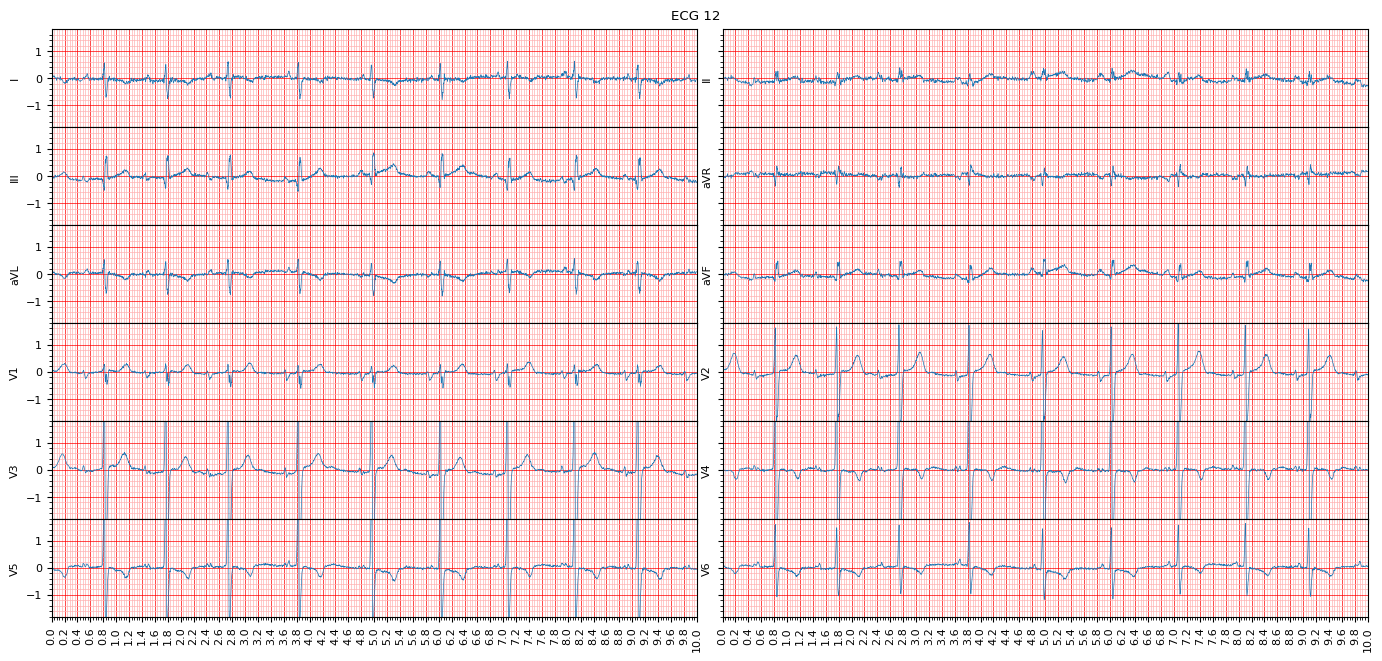

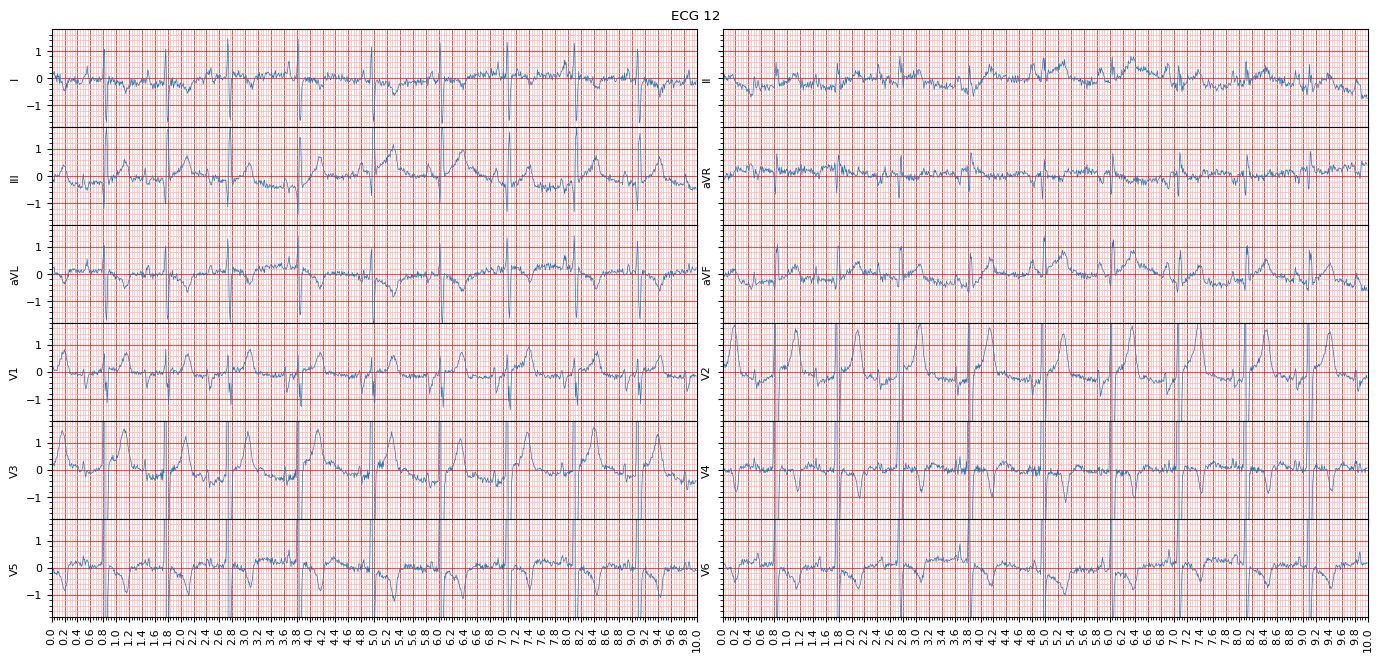

In [10]:
with tf.device('/CPU:0'):
    ecg_plot.plot_12(tf.transpose(X, perm=[0, 2, 1])[0], sample_rate=500)
    ecg_plot.plot_12(tf.transpose(X_final, perm=[0, 2, 1])[0], sample_rate=100)

### Loading the Model

In [11]:
ecg_age_model_2 = tf.keras.models.load_model("../saved_models/100hz/age_models/model_1.h5")
ecg_sex_model_2 = tf.keras.models.load_model("../saved_models/100hz/sex_models/model_1.h5")

X_final.shape

(10101, 1000, 12)

### Predictions

In [12]:
with tf.device('/CPU:0'):
    age_temp = ecg_age_model_2(tf.convert_to_tensor(X_final))
    sex_temp = ecg_sex_model_2(tf.convert_to_tensor(X_final))


predicted_age_unsorted = np.asarray(tf.squeeze(age_temp))
predicted_sex_prob = np.asarray(tf.squeeze(sex_temp))
predicted_sex = np.where((np.squeeze(np.where(predicted_sex_prob >= 0.50, 1, 0))) == 1, "Female", "Male")

In [13]:
predicted_sex_prob

array([0.09122156, 0.28986487, 0.18137157, ..., 0.0222696 , 0.6741875 ,
       0.9835387 ], dtype=float32)

#### Sorting the samples for better visualization

In [14]:
actual_ages = Y.Age.values.astype(int)
actual_sex = Y.Sex.values

sorted_indices = np.argsort(actual_ages)
actual_age_sorted = actual_ages[sorted_indices]
predicted_age_sorted = predicted_age_unsorted[sorted_indices]

### Evaluation Metrics

#### Mean Squared Error for Age
* Suboptimal but decent mae for a completely blind dataset

In [15]:
from sklearn.metrics import mean_absolute_error,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

mean_absolute_error(actual_age_sorted, predicted_age_sorted)

11.101184556253145

#### Accuracy For Sex
* Similar to the sex model, the accuracy of the sex model on a completely blind dataset with over 10k samples is rather decent.

In [16]:
accuracy_score(actual_sex, predicted_sex)

0.6943866943866944

### AUC for Sex prediction

In [43]:
from sklearn.metrics import roc_auc_score
actual_sex[actual_sex == 'Male'] = 0
actual_sex[actual_sex == 'Female'] = 1
actual_sex = actual_sex.astype(int)


roc_auc_score(actual_sex, predicted_sex_prob)

0.7993963272342036

### R-Squared for Age Prediction

In [46]:
from sklearn.metrics import r2_score
r2_score(actual_ages, predicted_age_unsorted)

0.10130684686236657

In [17]:
import seaborn as sns   # Remeber to install seaborn

def age_bar(actual, predicted):
    # Create a DataFrame from the data
    data = pd.DataFrame({'Category': np.squeeze(actual), 'Values': np.squeeze(predicted)})  # Merges the Actual and predicted data

    # Create a group boxplot using seaborn
    plt.figure(figsize=(25, 10))
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    sns.boxplot(x='Category', y='Values', data=data, width=0.6)   # Takes the unique values for X and plots them with all associated Y values. Thus a boxplot range is produced
    category_positions = range(len(data['Category'].unique()))
    plt.scatter(category_positions, np.unique(np.squeeze(actual)), color='black', label='Scatter Plot', alpha = 0.7)   # The true line represents what the predicted age should be. 
    plt.xlabel('Actual Age')
    plt.ylabel('Predicted Age')
    plt.yticks(range(0, 140, 5)) 
    plt.title("Evaluation of the Model")
    plt.show()

In [18]:
import itertools
from sklearn.metrics import confusion_matrix

figsize = (10, 10)

def make_confusion_matrix(y_actual, y_pred, classes, figsize=(18,18), text_size = 15):
    # Create the confusion matrix
    cm = confusion_matrix(y_actual, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0]

    # Let's prettify it
    fig, ax = plt.subplots(figsize=figsize)
    # Create a matrix plot
    cax = ax.matshow(cm, cmap=plt.cm.Blues) 
    fig.colorbar(cax)

    # Create classes
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title=("Confusion Matrix On Georgia Dataset"),
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels)

    # Set x-axis labels to bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Adjust label size
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.title.set_size(20)

    # Set threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=10)

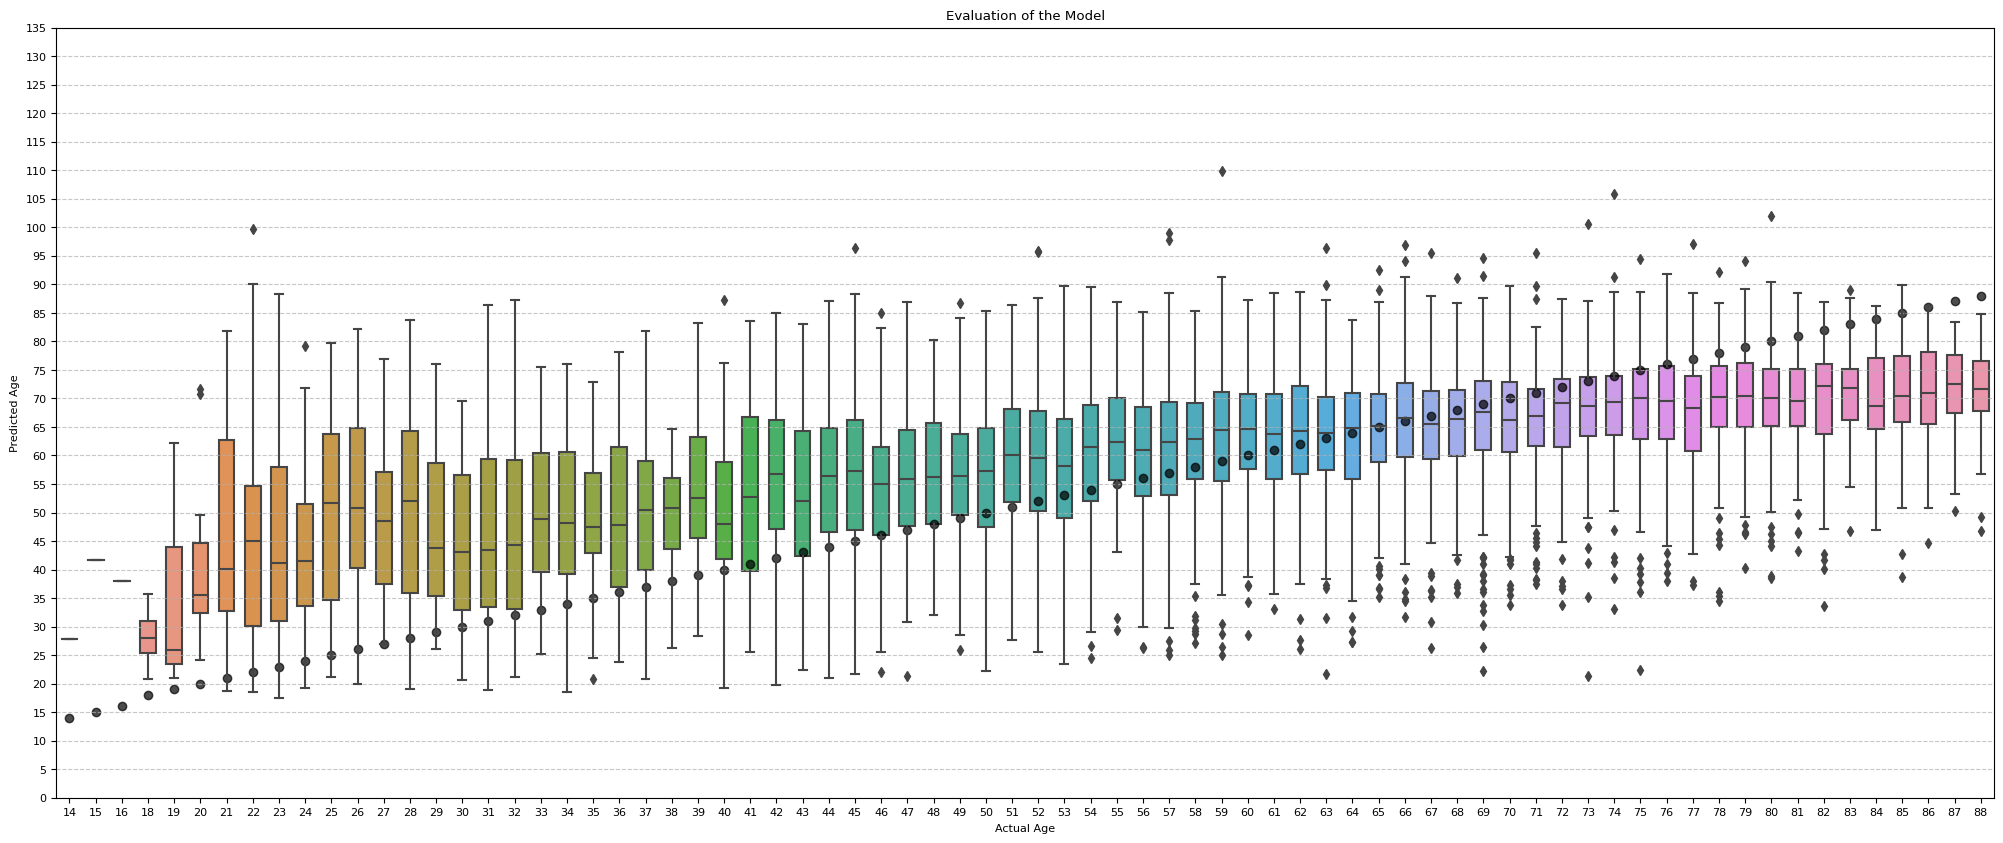

In [19]:
age_bar(actual_age_sorted, predicted_age_sorted)

In [20]:
actual_sex.astype(str), predicted_sex.astype(str)

(array(['Male', 'Male', 'Male', ..., 'Male', 'Female', 'Female'],
       dtype='<U6'),
 array(['Male', 'Male', 'Male', ..., 'Male', 'Female', 'Female'],
       dtype='<U6'))

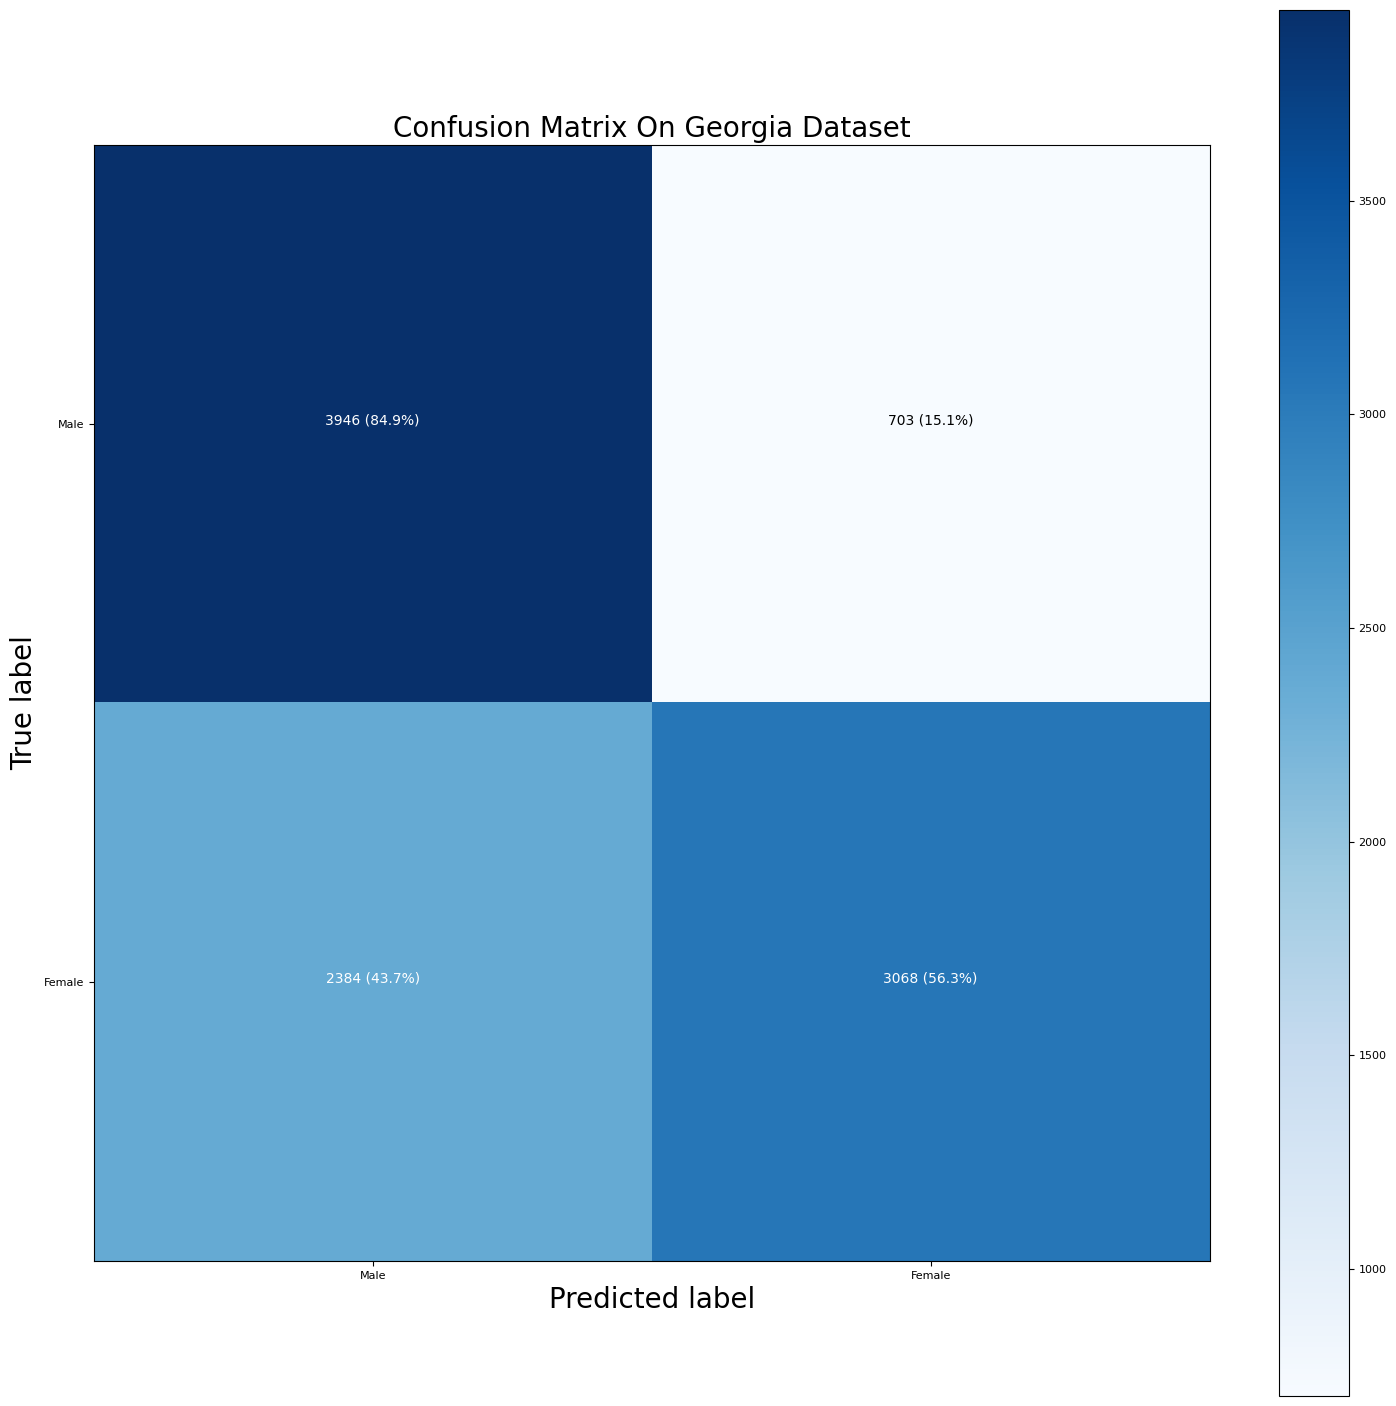

In [22]:
class_name = ['Male', 'Female']
make_confusion_matrix(actual_sex.astype(str), predicted_sex.astype(str), class_name)

(array([5452.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        4649.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

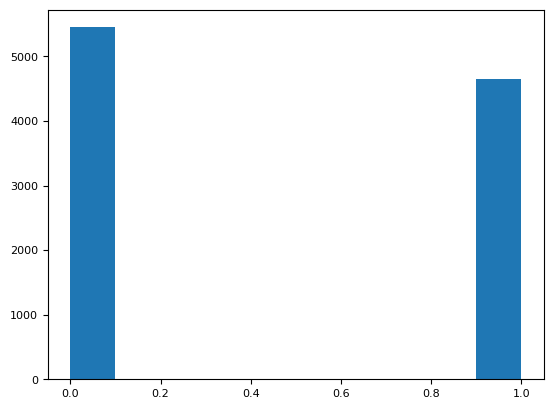

In [52]:
plt.hist(actual_sex)

(array([3771.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        6330.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

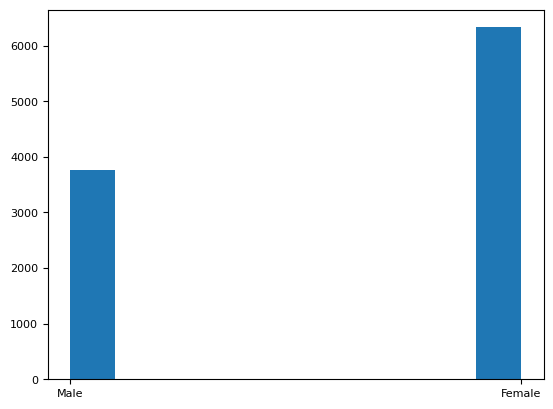

In [53]:
plt.hist(predicted_sex)

#### Sampling examples

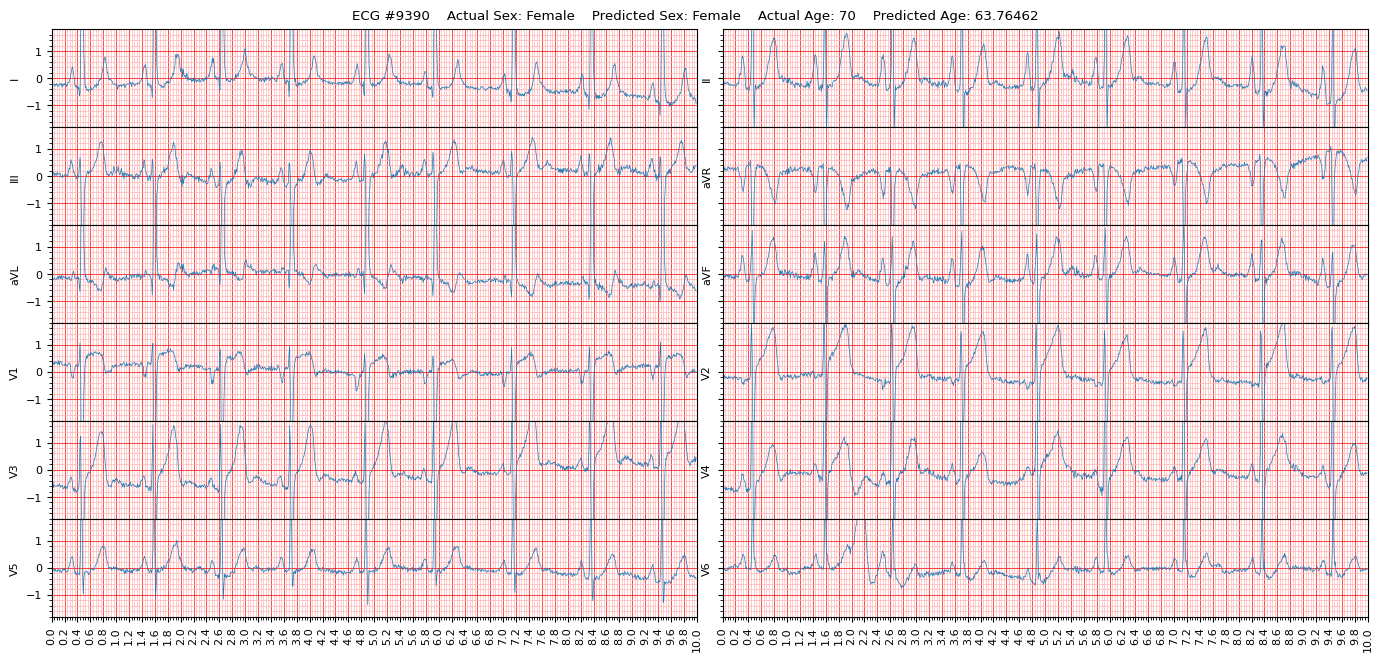

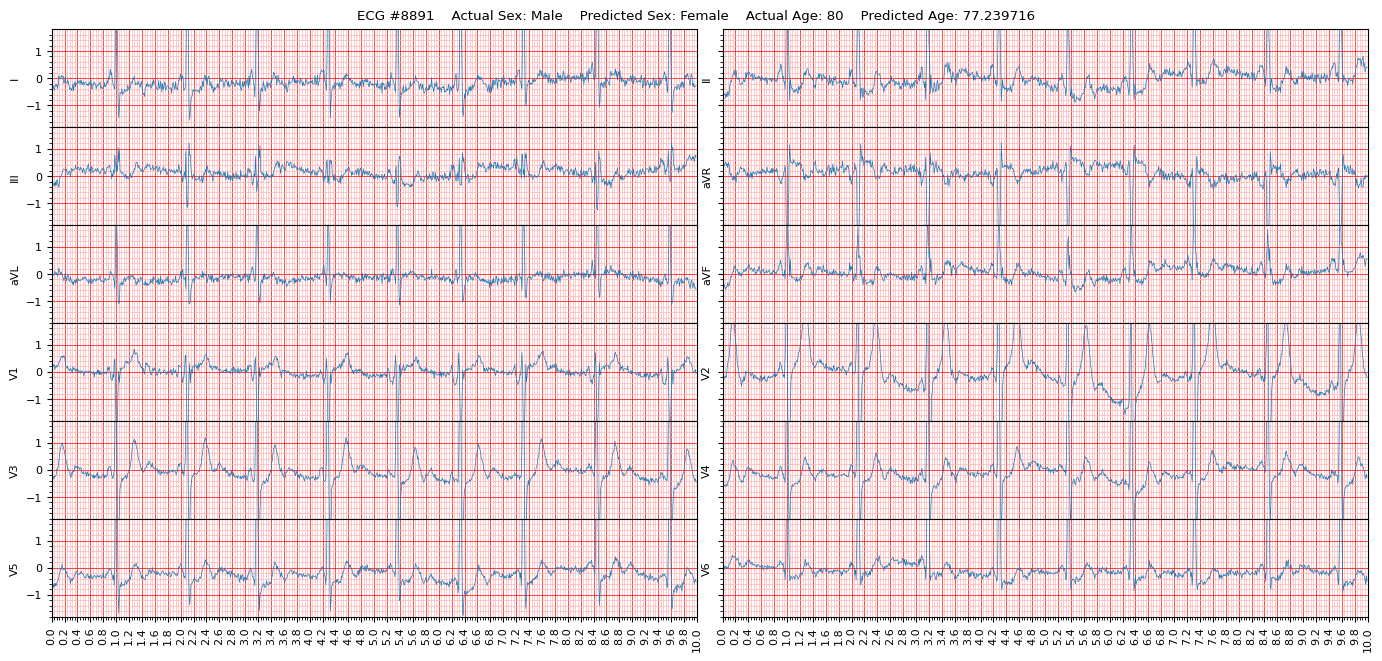

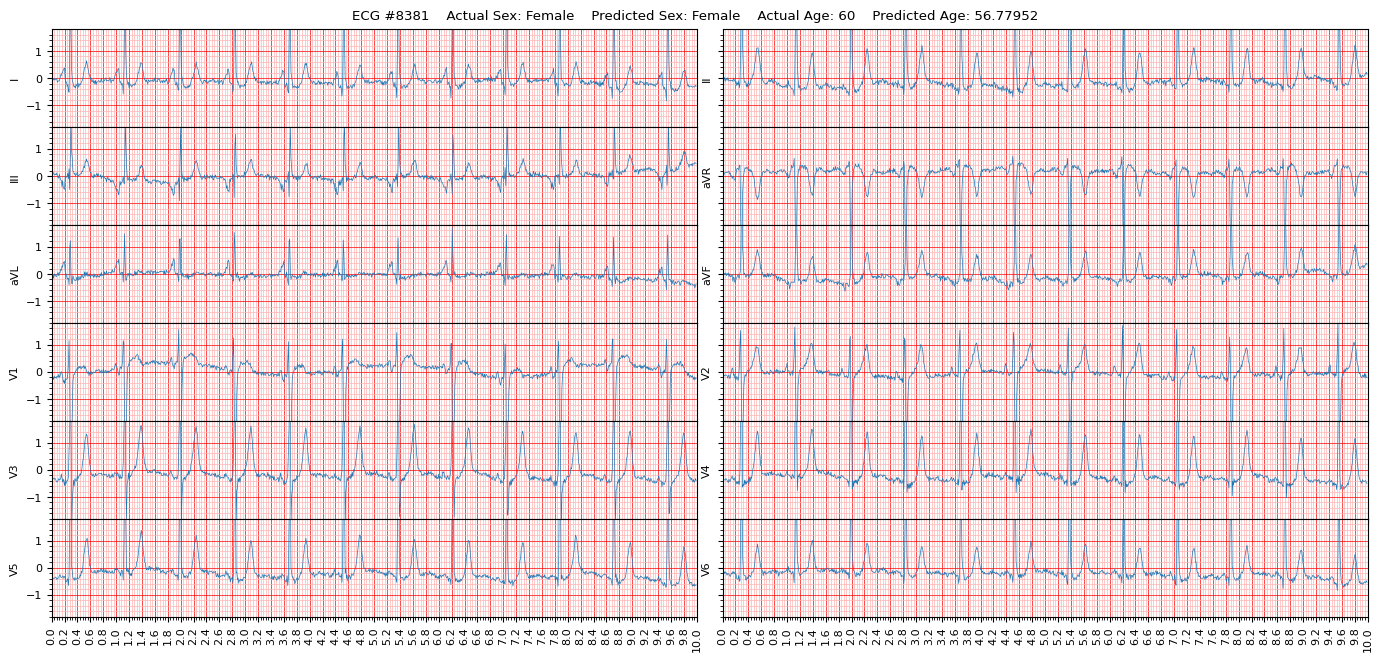

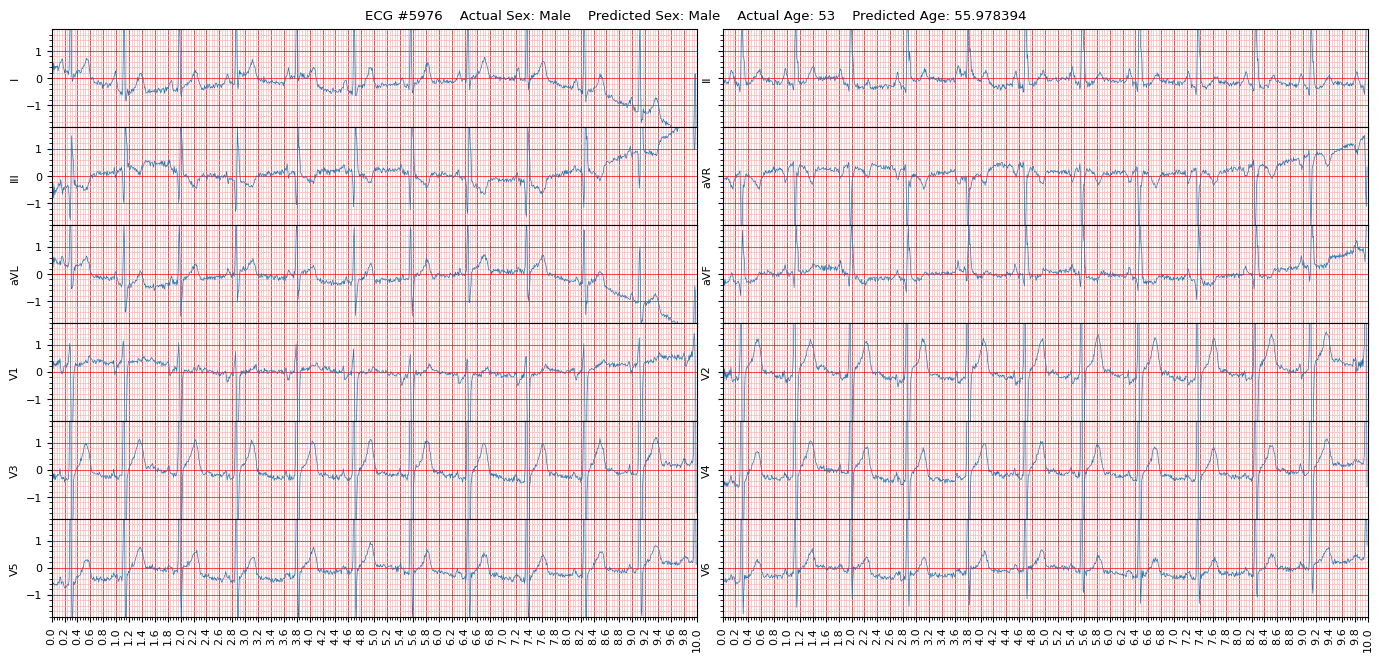

In [135]:
from random import choice

def visualize(X, actual_1, actual_2, predicted_1, predicted_2):
    for i in range(4):
        ind = choice(range(1, len(X)))
        plot_title = ("ECG #" + str(ind) + "    Actual Sex: " + actual_1[ind] + "    Predicted Sex: " + predicted_1[ind]  +
                      "    Actual Age: " + str(actual_2[ind]) + "    Predicted Age: " + str(predicted_2[ind]))
        ecg_plot.plot_12(tf.transpose(X, (0,2,1))[ind], sample_rate=100, title = plot_title)

with tf.device("/CPU:0"):
    visualize(X_final, actual_sex, actual_ages, predicted_sex, predicted_age_unsorted)